In [1]:
##################################
# IMPORTING BASE AND API LIBRARIES
##################################
from collections import Counter
import pandas as pd
from pandas import read_csv
import pandas_datareader as pdr
import datetime
# from pandas.tools.plotting import scatter_matrix
import numpy as np
from numpy import set_printoptions
import seaborn as sns
from matplotlib import pyplot
from pathlib import Path

# Import the main functionality from the SimFin Python API.
import simfin as sf
# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
##############################
# IMPORTING MODELING LIBRARIES
##############################
from sklearn import utils
from sklearn import preprocessing
from scipy.stats import uniform

# Pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import Binarizer

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier

# Resample, model eval, & metrics and enhancements 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.metrics import classification_report_imbalanced
from imblearn.combine import SMOTEENN
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import precision_recall_curve

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Ensemble for further improvements
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

# Performance tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Finalize model with Pickle and joblib
from pickle import dump
from pickle import load
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load

C:\Users\jenni\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Getting SimFin data

In [3]:
sf.__version__

'0.3.0'

In [4]:
sf.set_data_dir('~/simfin_data/')

# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

In [5]:
sns.set_style("whitegrid")

In [6]:
%%time
# Data for USA.
market = 'us'

# TTM Income Statements.
df_income_ttm = sf.load_income(variant='ttm', market=market)

# Quarterly Income Statements.
df_income_qrt = sf.load_income(variant='quarterly', market=market)

# TTM Balance Sheets.
df_balance_ttm = sf.load_balance(variant='ttm', market=market)

# TTM Cash-Flow Statements.
df_cashflow_ttm = sf.load_cashflow(variant='ttm', market=market)

# Quarterly Cash-Flow Statements.
df_cashflow_qrt = sf.load_cashflow(variant='quarterly', market=market)

# Latest Share-Prices.
# Use refresh_days=0 to always download the latest share-prices.
df_prices = sf.load_shareprices(variant='daily', market=market)
df_prices_latest = sf.load_shareprices(variant='latest', market=market,
                                       refresh_days=30)

Dataset "us-income-ttm" on disk (6 days old).
- Loading from disk ... Done!
Dataset "us-income-quarterly" on disk (6 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (6 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (6 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" on disk (6 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-daily" on disk (6 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-latest" on disk (6 days old).
- Loading from disk ... Done!
Wall time: 17.2 s


In [7]:
tickers = ['XLP','PG','KO','PEP','WMT','MO','PM','COST','MDLZ','CL','KMB','WBA','EL','SYY','GIS','STZ','TSN','ADM','MNST','HSY','KR','MKC','KHC','CLX','CHD','K','CAG','BF.B','HRL','LW','SJM','TAP','CPB','COTY']

df_income_qrt = df_income_qrt.loc[tickers].copy()
df_income_ttm = df_income_ttm.loc[tickers].copy()
df_balance_ttm = df_balance_ttm.loc[tickers].copy()
df_cashflow_ttm = df_cashflow_ttm.loc[tickers].copy()
df_cashflow_qrt = df_cashflow_qrt.loc[tickers].copy()
# df_prices_latest = df_prices_latest.loc[tickers].copy()

In [8]:
# df_prices_latest.tail()

In [9]:
# Getting signals for last day of every year
df_price_list = []
df_fin_signals_list = []
df_growth_signals_list = []
df_val_signals_list = []

# setting the price and signals data frames (not including latest year)
shareprice_last_dates = ["2011-12-30", "2012-12-31", "2013-12-31", "2014-12-31", "2015-12-31","2016-12-30", "2017-12-29", "2018-12-31"]

for i in range(len(shareprice_last_dates)):
    df_price_list.append(df_prices.loc[(df_prices.index.get_level_values('Date') == shareprice_last_dates[i])])
    df_fin_signals_list.append(sf.fin_signals(df_prices=df_price_list[i],
                                              df_income_ttm=df_income_ttm,
                                              df_balance_ttm=df_balance_ttm,
                                              fill_method='ffill'))
    df_growth_signals_list.append(sf.growth_signals(df_prices=df_price_list[i],
                                                    df_income_ttm=df_income_ttm,
                                                    df_income_qrt=df_income_qrt,
                                                    df_cashflow_ttm=df_cashflow_ttm,
                                                    df_cashflow_qrt=df_cashflow_qrt,
                                                    fill_method='ffill'))
    df_val_signals_list.append(sf.val_signals(df_prices=df_price_list[i],
                                              df_income_ttm=df_income_ttm,
                                              df_balance_ttm=df_balance_ttm,
                                              df_cashflow_ttm=df_cashflow_ttm,
                                              fill_method='ffill'))

In [10]:
# Latest year signals
df_fin_signals = \
    sf.fin_signals(df_prices=df_prices_latest,
                   df_income_ttm=df_income_ttm,
                   df_balance_ttm=df_balance_ttm,
                   fill_method='ffill')

df_growth_signals = \
    sf.growth_signals(df_prices=df_prices_latest,
                      df_income_ttm=df_income_ttm,
                      df_income_qrt=df_income_qrt,
                      df_cashflow_ttm=df_cashflow_ttm,
                      df_cashflow_qrt=df_cashflow_qrt,
                      fill_method='ffill')

df_val_signals = \
    sf.val_signals(df_prices=df_prices_latest,
                   df_income_ttm=df_income_ttm,
                   df_balance_ttm=df_balance_ttm,
                   df_cashflow_ttm=df_cashflow_ttm,
                   fill_method='ffill')

In [11]:
# Combine the DataFrames (for latest)
dfs = [df_fin_signals, df_growth_signals, df_val_signals]
df_signals = pd.concat(dfs, axis=1)
df_signals = df_signals.loc[tickers].copy()
# Show the result.
print("Signals")
df_signals.shape

Signals


(30, 25)

In [12]:
df_signals.tail()

,,Current Ratio,Debt Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,...,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
Ticker,Date,,,,,,,,,,,,,,,,,,,,,
SYY,2019-11-21,1.300822,0.476761,0.189250,0.026477,0.085212,0.664999,0.233428,0.645908,0.333241,0.039732,...,0.018320,0.038141,0.041405,4.162045e+10,17.363869,26.218711,24.151738,-5.663961,-4.016191,0.694195
TAP,2019-11-21,0.348035,0.321801,0.386010,0.014669,0.005061,0.010944,-0.906540,-2.222829,-2.191364,-0.296345,...,0.034192,0.013536,0.117289,1.139153e+10,0.849702,73.875008,8.525953,-0.872366,-0.819502,1.083679
TSN,2019-11-21,1.328033,0.373860,0.126012,0.052746,0.076472,0.176087,-0.239847,0.586854,0.249538,-0.321053,...,0.015729,0.067542,0.039785,3.242411e+10,2.292915,14.805531,25.134971,-2.681673,-2.132534,0.780928
WBA,2019-11-21,0.784492,0.256141,0.225949,0.037723,0.072498,0.182199,0.241896,0.030276,-0.142328,-0.042293,...,0.030207,0.087866,0.093787,5.843010e+10,2.299221,11.381009,10.662427,-2.321142,-1.757825,0.429327
WMT,2019-11-21,0.772819,0.229027,0.250198,0.016248,0.040883,0.106966,-0.064642,0.042040,0.800375,-0.151875,...,0.017369,0.023899,0.045034,3.505605e+11,4.679756,41.842986,22.205646,-3.580985,-2.827169,0.679855


In [13]:
# Combine the DataFrames (for the previous years.)
dfs_list = [[df_fin_signals_list[i], df_growth_signals_list[i], df_val_signals_list[i]] for i in range(len(df_fin_signals_list))]
df_signals_list = [pd.concat(e, axis=1) for e in dfs_list]
df_signals_list = [e.loc[tickers].copy() for e in df_signals_list]

In [14]:
# Show an example.
print("2018 Signals")
df_signals_list[7].head()

2018 Signals


,,Current Ratio,Debt Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,...,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
Ticker,Date,,,,,,,,,,,,,,,,,,,,,
ADM,2018-12-31,1.748302,0.205422,0.064982,0.028131,0.045292,0.098503,0.134796,-0.412313,-0.600254,-5.005158,...,0.032630,0.077917,-0.233965,2.322999e+10,1.219742,12.834249,-4.274147,-19.358325,-1.695156,0.361045
CAG,2018-12-31,1.465831,0.502612,0.289395,0.090747,0.071365,0.196012,0.049788,-0.261504,-0.411186,-0.380579,...,0.039055,0.086013,0.058547,8.628906e+09,1.181508,11.626120,17.080178,-0.694306,-0.630871,1.055033
CHD,2018-12-31,0.812938,0.347179,0.444005,0.137148,0.094533,0.256357,-0.235136,-0.023923,-0.647929,0.104792,...,0.012938,0.034490,0.042654,1.648603e+10,6.718572,28.994077,23.444300,-6.497727,-5.787974,3.976466
CL,2018-12-31,1.135289,0.523477,0.593863,0.154400,0.189334,9.876543,0.185771,0.158700,0.876161,0.047581,...,0.030619,0.046189,0.050422,5.196096e+10,263.761218,21.650400,19.832427,-6.359192,-5.433542,3.342831
CLX,2018-12-31,1.150927,0.496747,0.434657,0.126521,0.166036,1.039474,-0.010025,-0.133333,-0.218884,0.269177,...,0.023709,0.039184,0.045136,2.016151e+10,27.171849,25.520901,22.155508,-6.797543,-5.786886,3.228942


In [15]:
df_signals_list[7].shape

(30, 25)

Output of the previous section are `df_signals` (Signals for latest year) `df_signals_list` (Signals for previous years)



# Getting Data from Yahoo Finance

In [16]:
start_sp = datetime.datetime(2011, 1, 1)
end_sp = datetime.datetime(2019, 12, 31)

In [17]:
ticker_symbols_list = ['XLP','PG','KO','PEP','WMT','MO','PM','COST','MDLZ','CL','KMB','WBA','EL','SYY','GIS','STZ','TSN','ADM','MNST','HSY','KR','MKC','KHC','CLX','CHD','K','CAG','BF.B','HRL','LW','SJM','TAP','CPB','COTY']
# create a yearly dataframe with all features, returns (2), nlp, 3 years (2017-2018 on 2019)

In [18]:
close_price_df = pdr.get_data_yahoo(ticker_symbols_list, start_sp, end_sp)['Close']

C:\Users\jenni\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'BF.B', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


In [19]:
close_price_df.shape

(2255, 34)

In [20]:
# Yearly returns
multpl_stock_yearly_returns = close_price_df.resample('Y').ffill().pct_change()
multpl_stock_yearly_returns.head()

Symbols,XLP,PG,KO,PEP,WMT,MO,PM,COST,MDLZ,CL,...,CHD,K,CAG,HRL,LW,SJM,TAP,CPB,COTY,BF.B
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-31,0.074177,0.017689,0.036158,0.031349,0.141734,0.060371,0.065749,0.184950,-0.318790,0.131508,...,0.170673,0.104410,0.117424,0.065551,NaN,0.103237,-0.017226,0.049639,NaN,NaN
2013-12-31,0.231519,0.199146,0.139586,0.212042,0.153305,0.221056,0.041726,0.205510,0.387033,0.247561,...,0.237260,0.093465,0.142373,0.447293,NaN,0.201531,0.312222,0.240470,NaN,NaN
2014-12-31,0.128199,0.118904,0.022029,0.140101,0.091371,0.283407,-0.065190,0.190976,0.029179,0.061034,...,0.189046,0.071557,0.076558,0.153420,NaN,-0.025478,0.327159,0.016636,0.354754,NaN
2015-12-31,0.041246,-0.128225,0.017527,0.056684,-0.286213,0.181449,0.079313,0.139330,0.234242,-0.037144,...,0.077021,0.104370,0.162073,0.517850,NaN,0.221430,0.260333,0.194318,0.240561,NaN


In [21]:
# Melting yearly returns
multpl_stock_yearly_returns = multpl_stock_yearly_returns.reset_index(drop = False)
multpl_stock_yearly_returns_melt = multpl_stock_yearly_returns.melt(id_vars=["Date", "XLP"], 
        var_name="TickerSymbol", 
        value_name="YearlyReturn")

In [22]:
multpl_stock_yearly_returns_melt.tail()

,Date,XLP,TickerSymbol,YearlyReturn
292,2015-12-31,0.041246,BF.B,NaN
293,2016-12-31,0.024163,BF.B,NaN
294,2017-12-31,0.100174,BF.B,NaN
295,2018-12-31,-0.107400,BF.B,NaN
296,2019-12-31,0.238677,BF.B,NaN


In [23]:
# changing XLP returns column name
multpl_stock_yearly_returns_melt.rename(columns = {'XLP':'XLP_Return'}, inplace = True)

In [24]:
multpl_stock_yearly_returns_melt.head()

,Date,XLP_Return,TickerSymbol,YearlyReturn
0,2011-12-31,NaN,PG,NaN
1,2012-12-31,0.074177,PG,0.017689
2,2013-12-31,0.231519,PG,0.199146
3,2014-12-31,0.128199,PG,0.118904
4,2015-12-31,0.041246,PG,-0.128225


In [26]:
threshold = 0.05 
delta_value = threshold * multpl_stock_yearly_returns_melt['YearlyReturn']
win = np.where(multpl_stock_yearly_returns_melt['XLP_Return'] - multpl_stock_yearly_returns_melt['YearlyReturn'] >= delta_value, 0, 1)

In [27]:
multpl_stock_yearly_returns_melt['win'] = win

In [28]:
multpl_stock_yearly_returns_melt = multpl_stock_yearly_returns_melt.sort_values(by=['Date','TickerSymbol'])
multpl_stock_yearly_returns_melt.tail()

,Date,XLP_Return,TickerSymbol,YearlyReturn,win
116,2019-12-31,0.238677,SYY,0.342802,1
269,2019-12-31,0.238677,TAP,-0.066061,0
143,2019-12-31,0.238677,TSN,0.692509,1
98,2019-12-31,0.238677,WBA,-0.164496,0
35,2019-12-31,0.238677,WMT,0.301986,1


In [29]:
multpl_stock_yearly_returns_melt = multpl_stock_yearly_returns_melt.reset_index(drop = True)
multpl_stock_yearly_returns_melt.head()

,Date,XLP_Return,TickerSymbol,YearlyReturn,win
0,2011-12-31,NaN,ADM,NaN,1
1,2011-12-31,NaN,BF.B,NaN,1
2,2011-12-31,NaN,CAG,NaN,1
3,2011-12-31,NaN,CHD,NaN,1
4,2011-12-31,NaN,CL,NaN,1


In [30]:
for e in df_signals_list:
    print(e.shape)

(28, 25)
(28, 25)
(29, 25)
(29, 25)
(30, 25)
(30, 25)
(30, 25)
(30, 25)


In [31]:
# Replacing NaNs with median of columns
for e in df_signals_list:
    for col in e:
        e[col] = e[col].fillna(e[col].median())

In [32]:
# appending signals dfs
all_years_signals = df_signals_list[0]
for i in range(1, len(df_signals_list)):
    all_years_signals = all_years_signals.append(df_signals_list[i])

In [33]:
all_years_signals.tail()

,,Current Ratio,Debt Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,...,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
Ticker,Date,,,,,,,,,,,,,,,,,,,,,
SYY,2018-12-31,1.250010,0.484330,0.188911,0.024770,0.081091,0.641770,0.236138,-0.379689,-0.058896,-0.198119,...,0.022829,0.044706,0.045855,3.304816e+10,15.001482,22.368604,21.807733,-4.375269,-3.153242,0.554068
TAP,2018-12-31,0.643191,0.348335,0.388575,0.103671,0.036913,0.083104,-0.210508,-0.774623,-0.875000,0.290009,...,0.029118,0.091785,0.140748,1.216426e+10,0.885588,10.894990,7.104875,-0.893924,-0.840758,1.129499
TSN,2018-12-31,0.848048,0.370867,0.125700,0.048581,0.069315,0.162352,-0.308677,0.026071,-0.662170,0.039972,...,0.023271,0.098993,0.075517,1.963785e+10,1.481096,10.101775,13.241976,-1.537209,-1.277799,0.490750
WBA,2018-12-31,0.800151,0.228621,0.231013,0.039572,0.079948,0.199058,0.385176,-0.257275,0.367844,0.092918,...,0.026102,0.079530,0.104153,6.696852e+10,2.549919,12.573887,9.601222,-2.838251,-2.102490,0.497574
WMT,2018-12-31,0.809856,0.269177,0.251710,0.010077,0.024631,0.065369,-0.549283,-2.986063,-0.022298,-0.002386,...,0.022168,0.018723,0.068289,2.754911e+11,3.466649,53.410455,14.643657,-3.547035,-2.541167,0.538196


In [34]:
all_years_signals = all_years_signals.reset_index(drop = True)

In [35]:
all_years_signals.tail()

,Current Ratio,Debt Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,...,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
229,1.250010,0.484330,0.188911,0.024770,0.081091,0.641770,0.236138,-0.379689,-0.058896,-0.198119,...,0.022829,0.044706,0.045855,3.304816e+10,15.001482,22.368604,21.807733,-4.375269,-3.153242,0.554068
230,0.643191,0.348335,0.388575,0.103671,0.036913,0.083104,-0.210508,-0.774623,-0.875000,0.290009,...,0.029118,0.091785,0.140748,1.216426e+10,0.885588,10.894990,7.104875,-0.893924,-0.840758,1.129499
231,0.848048,0.370867,0.125700,0.048581,0.069315,0.162352,-0.308677,0.026071,-0.662170,0.039972,...,0.023271,0.098993,0.075517,1.963785e+10,1.481096,10.101775,13.241976,-1.537209,-1.277799,0.490750
232,0.800151,0.228621,0.231013,0.039572,0.079948,0.199058,0.385176,-0.257275,0.367844,0.092918,...,0.026102,0.079530,0.104153,6.696852e+10,2.549919,12.573887,9.601222,-2.838251,-2.102490,0.497574
233,0.809856,0.269177,0.251710,0.010077,0.024631,0.065369,-0.549283,-2.986063,-0.022298,-0.002386,...,0.022168,0.018723,0.068289,2.754911e+11,3.466649,53.410455,14.643657,-3.547035,-2.541167,0.538196


In [36]:
print(multpl_stock_yearly_returns_melt.shape)
print(all_years_signals.shape)

(297, 5)
(234, 25)


In [37]:
# Separating latest data
# multpl_stock_yearly_returns_melt['Date'] = pd.to_datetime(multpl_stock_yearly_returns_melt['Date'])
yearly_returns_latest_df = multpl_stock_yearly_returns_melt[multpl_stock_yearly_returns_melt['Date'].dt.year == 2019]
yearly_returns_df = multpl_stock_yearly_returns_melt[multpl_stock_yearly_returns_melt['Date'].dt.year != 2019]

In [38]:
print(yearly_returns_df.shape)
print(yearly_returns_latest_df.shape)

(264, 5)
(33, 5)


In [39]:
yearly_returns_df = yearly_returns_df.drop(columns = ["TickerSymbol", "Date"])
yearly_returns_latest_df = yearly_returns_latest_df.drop(columns = ["TickerSymbol", "Date"])

In [40]:
yearly_returns_df = yearly_returns_df.reset_index(drop = True)
yearly_returns_latest_df = yearly_returns_latest_df.reset_index(drop = True)

In [41]:
print(yearly_returns_df.shape)
print(all_years_signals.shape)

(264, 3)
(234, 25)


In [42]:
final_df = pd.concat([yearly_returns_df, all_years_signals], axis=1)

In [43]:
final_df.tail(15)

,XLP_Return,YearlyReturn,win,Current Ratio,Debt Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity,Earnings Growth,...,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
249,-0.1074,0.303100,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,-0.1074,-0.064720,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,-0.1074,0.366304,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252,-0.1074,-0.222310,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253,-0.1074,-0.308360,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,-0.1074,-0.078719,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
255,-0.1074,0.000435,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256,-0.1074,-0.368102,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257,-0.1074,-0.247505,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258,-0.1074,-0.296408,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
final_df.shape

(264, 28)

In [45]:
df_signals = df_signals.reset_index(drop = True)

In [46]:
print(yearly_returns_latest_df.shape)
print(df_signals.shape)

(33, 3)
(30, 25)


In [47]:
df_signals.head()

,Current Ratio,Debt Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,...,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
0,1.516503,0.229056,0.065815,0.025733,0.040146,0.087785,0.000606,-0.260317,-0.407125,0.478921,...,0.031536,0.067930,-0.160315,2.428964e+10,1.281167,14.720997,-6.237711,-6.180571,-1.437448,0.378821
1,1.113515,0.471024,0.277571,0.066758,0.064273,0.176645,-0.192063,0.373913,-0.024691,0.362285,...,0.028444,0.050912,0.065765,1.323659e+10,1.760934,19.641773,15.205733,-1.093057,-0.994266,1.311242
2,0.812938,0.347179,0.444005,0.137148,0.094533,0.256357,-0.235136,-0.023923,-0.647929,0.104792,...,0.012338,0.032889,0.040675,1.728827e+10,7.045510,30.404981,24.585142,-6.813918,-6.069628,4.169968
3,1.027889,0.542460,0.591646,0.150429,0.185347,-34.264706,0.100614,-0.013652,0.105163,0.090614,...,0.027921,0.040432,0.046575,5.762694e+10,331.189332,24.732594,21.470545,-5.486713,-4.763640,3.720508
4,1.104679,0.505037,0.436126,0.126792,0.146216,0.951016,-0.013631,0.027473,0.033149,0.047120,...,0.026019,0.042096,0.042307,1.890938e+10,24.211748,23.755497,23.636719,-6.328439,-5.426322,3.012006


In [48]:
final_test_df= pd.concat([yearly_returns_latest_df, df_signals], axis=1)
final_test_df.shape
# df_signals.head()

(33, 28)

Output of the previous section are `final_df` (for train data) `final_test_df` (for test data), both including `win` column

In [48]:
# final_df.isnull().sum()

In [49]:
# df_signals_list[5].isnull().sum()

# Add additional features

In [50]:
# NLP, FRED

# Data discovery and visualizations

In [49]:
master_df = pd.concat([final_df, final_test_df], axis = 0)
# master_df.shape

In [50]:
master_df.isnull().sum()

XLP_Return             33
YearlyReturn           52
win                     0
Current Ratio          34
Debt Ratio             35
Gross Profit Margin    34
Net Profit Margin      34
Return on Assets       34
Return on Equity       34
Earnings Growth        34
Earnings Growth QOQ    34
Earnings Growth YOY    35
FCF Growth             34
FCF Growth QOQ         34
FCF Growth YOY         35
Sales Growth           34
Sales Growth QOQ       34
Sales Growth YOY       35
Dividend Yield         35
Earnings Yield         34
FCF Yield              34
Market-Cap             34
P/Book                 34
P/E                    34
P/FCF                  34
P/NCAV                 34
P/NetNet               34
P/Sales                34
dtype: int64

In [215]:
# master_df.describe()

In [216]:
# correlations = master_df.corr()

In [217]:
# fig = pyplot.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(correlations, vmin=-1, vmax=1)
# fig.colorbar(cax)
# pyplot.show()

# Feature Engineering  

In [218]:
# Feature selection - Univariate, recursive feature elimination, PCA and feature importance

In [219]:
# master_df = master_df[~master_df.isin([np.nan, np.inf, -np.inf]).any(1)]
# master_df.shape # 550*25
# X = master_df.iloc[:,1:]
# Y = master_df['win']

In [220]:
# from sklearn.ensemble import ExtraTreesClassifier
# import matplotlib.pyplot as plt

# model = ExtraTreesClassifier()
# model.fit(X,Y)
# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()

In [221]:
# univariate - non-negative input
# test = SelectKBest(score_func=chi2, k=4)
# fit = test.fit(X, Y)
# set_printoptions(precision=3)
# print(fit.scores_)
# features = fit.transform(X)
# # summarize selected features
# print(features[0:5,:])

In [222]:
# PCA
# pca = PCA(n_components=3)
# fit = pca.fit(X)

In [223]:
# feature extraction
# model = LogisticRegression()
# rfe = RFE(model, 3)
# fit = rfe.fit(X, Y)
# print("Num Features: %d") % fit.n_features_
# print("Selected Features: %s") % fit.support_
# print("Feature Ranking: %s") % fit.ranking_

# Create target and features for train and test

In [51]:
print(final_df.shape)
print(final_test_df.shape)

(264, 28)
(33, 28)


In [52]:
names = list(final_df.columns)
names[0], names[2] = names[2], names[0]
final_df = final_df.reindex(names, axis=1)

names = list(final_test_df.columns)
names[0], names[2] = names[2], names[0]
final_test_df = final_test_df.reindex(names, axis=1)

In [53]:
final_test_df.head()

,win,YearlyReturn,XLP_Return,Current Ratio,Debt Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity,Earnings Growth,...,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
0,0,0.127898,0.238677,1.516503,0.229056,0.065815,0.025733,0.040146,0.087785,0.000606,...,0.031536,0.067930,-0.160315,2.428964e+10,1.281167,14.720997,-6.237711,-6.180571,-1.437448,0.378821
1,1,NaN,0.238677,1.113515,0.471024,0.277571,0.066758,0.064273,0.176645,-0.192063,...,0.028444,0.050912,0.065765,1.323659e+10,1.760934,19.641773,15.205733,-1.093057,-0.994266,1.311242
2,1,0.366573,0.238677,0.812938,0.347179,0.444005,0.137148,0.094533,0.256357,-0.235136,...,0.012338,0.032889,0.040675,1.728827e+10,7.045510,30.404981,24.585142,-6.813918,-6.069628,4.169968
3,0,0.045316,0.238677,1.027889,0.542460,0.591646,0.150429,0.185347,-34.264706,0.100614,...,0.027921,0.040432,0.046575,5.762694e+10,331.189332,24.732594,21.470545,-5.486713,-4.763640,3.720508
4,0,0.139785,0.238677,1.104679,0.505037,0.436126,0.126792,0.146216,0.951016,-0.013631,...,0.026019,0.042096,0.042307,1.890938e+10,24.211748,23.755497,23.636719,-6.328439,-5.426322,3.012006


In [54]:
# drop the yearly returns and market-cap
final_df = final_df.drop(columns = ["YearlyReturn", "XLP_Return", "Market-Cap"])
final_test_df = final_test_df.drop(columns = ["YearlyReturn", "XLP_Return", "Market-Cap"])

In [55]:
train_array = final_df.values
test_array = final_test_df.values

In [56]:
Y_train = train_array[0:,0]
Y_test = test_array[0:,0]

In [57]:
X_train = train_array[0:,1:]
X_test = test_array[0:,1:]

In [58]:
# np.savetxt("foo.csv", array, delimiter=",")
print(X_train.shape)
print(X_test.shape)

(264, 24)
(33, 24)


In [59]:
Y_test

array([0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1.])

In [60]:
# mask = ~np.any(np.isnan(X_train), axis=1)
# mask_test = ~np.any(np.isnan(X_test), axis=1)

# X_train = X_train[mask]
# Y_train = Y_train[mask]

# X_test = X_test[mask_test]
# Y_test = Y_test[mask_test]

In [61]:
## The one we use
X_train[np.where(np.isnan(X_train))] = np.take(np.nanmedian(X_train, axis=0), np.where(np.isnan(X_train))[1])
X_test[np.where(np.isnan(X_test))] = np.take(np.nanmedian(X_test, axis=0), np.where(np.isnan(X_test))[1])

In [62]:
# replace posinf with max value
X_train[np.where(np.isposinf(X_train))] = np.NINF
X_train[np.where(np.isneginf(X_train))] = np.take(np.max(X_train, axis=0), np.where(np.isneginf(X_train))[1])

In [63]:
np.any(np.isnan(X_train))

False

In [64]:
np.any(np.isinf(X_train))

False

In [238]:
# X_train= preprocessing.normalize(X_train, norm='l2')
# X_test = preprocessing.normalize(X_test, norm='l2')

In [65]:
print(X_train.shape)
print(X_test.shape)

(264, 24)
(33, 24)


In [66]:
# Creating X and Y 
# X = np.append(X_train, X_test, axis=0)
# Y = np.append(Y_train, Y_test, axis=0)
X = X_train
Y = Y_train

# Model Pre-processing: Scale, standardize, normalize or binarize

In [241]:
# Scale
# scaler = MinMaxScaler(feature_range=(0, 1))
# rescaledX = scaler.fit_transform(X)
# # summarize transformed data
# set_printoptions(precision=3)

In [67]:
# Standardize
scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)
# summarize transformed data
set_printoptions(precision=3)
print(rescaledX[0:5,:])

[[ 5.401e-01 -3.019e-01 -2.368e+00 -1.007e+00 -6.196e-01 -2.651e-01
   2.263e-01 -1.374e-01  5.316e-02 -9.184e+00 -4.047e-01  1.153e-01
   1.038e+00  1.608e-01  2.328e+00 -3.442e-01  1.591e+00 -6.138e+00
  -4.032e-02 -8.068e-01 -1.066e+00  1.638e-01  1.321e-01 -1.365e+00]
 [ 5.094e-01 -8.471e-01 -1.224e+00 -6.062e-01 -5.726e-01 -2.534e-01
   2.733e-01 -7.507e-02  1.004e-02  4.848e-01 -7.841e-02 -1.045e-01
   2.905e-01  7.624e-02  2.989e-01  6.282e-01  5.407e-01  1.232e+00
  -3.049e-02 -4.515e-01 -4.793e-01  6.495e-02  6.691e-02 -9.671e-01]
 [ 9.132e-01 -2.116e+00  3.348e-01  6.562e-02 -7.854e-02 -1.563e-01
  -1.084e-02 -7.908e-02  7.442e-02 -2.446e-01  9.424e-02 -1.817e-01
   1.484e-01  7.624e-02  1.641e-01 -9.415e-01 -6.976e-02  2.268e-01
  -2.408e-02  4.821e-02 -2.245e-01 -1.051e-01 -8.047e-01  9.612e-02]
 [-3.528e-01  4.379e-02  1.247e+00  5.770e-01  1.983e+00  2.686e-01
   7.927e-02 -6.688e-02  3.142e-02 -1.336e-01  2.603e-01 -1.366e-01
   1.256e-01  1.703e-01  4.179e-01  1.844e+00

In [243]:
# Normalize
# scaler = Normalizer().fit(X)
# normalizedX = scaler.transform(X)
# # summarize transformed data
# set_printoptions(precision=3)
# print(normalizedX[0:5,:])

In [244]:
# Binarize
# binarizer = Binarizer(threshold=0.0).fit(X)
# binaryX = binarizer.transform(X)
# # summarize transformed data
# set_printoptions(precision=3)
# print(binaryX[0:5,:])

In [68]:
X = rescaledX

# Classification algorithms

In [246]:
# Classification: Logisitc, LDA, k-nearest neighbors, Naive bayes, classification and regression trees, & SVM

In [69]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
best = -np.inf
best_model = None
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    if cv_results.mean() > best:
        best = cv_results.mean()
        best_model = model
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.611966 (0.127375)
LDA: 0.620085 (0.109262)
KNN: 0.582336 (0.159111)
CART: 0.563960 (0.132741)
NB: 0.608262 (0.118325)
SVM: 0.661538 (0.160598)


In [70]:
best

0.6615384615384615

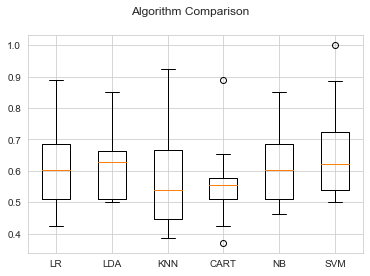

In [71]:
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

# Improve performance with Ensemble models

In [72]:
# bagging (bag decision trees, random forest, extra trees), boosting (adaBoost, gradient), voting (combine multiple)

In [73]:
# Bagged decision trees
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
cart = best_model
num_trees = 100
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.6615384615384615


In [74]:
# Random forest
num_trees = 100
max_features = 3
kfold = KFold(n_splits=10, random_state=7)
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.6239316239316238


In [75]:
# Extra trees
num_trees = 100
max_features = 7
kfold = KFold(n_splits=10, random_state=7)
model = ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.577920227920228


In [76]:
# AdaBoost
num_trees = 30
seed=7
kfold = KFold(n_splits=10, random_state=seed)
model = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.5588319088319088


In [77]:
# Stochastic gradient
seed = 7
num_trees = 100
kfold = KFold(n_splits=10, random_state=seed)
model = GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.5891737891737892


In [78]:
# Voting
kfold = KFold(n_splits=10, random_state=7)
# create the sub models
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = GaussianNB()
estimators.append(('cart', model2))
model3 = SVC()
estimators.append(('svm', model3))
# create the ensemble model
ensemble = VotingClassifier(estimators)
results = cross_val_score(ensemble, X, Y, cv=kfold)
print(results.mean())

0.6462962962962963


# Improve performance with Algorithm tunning

In [257]:
# Using grid search and random search

In [258]:
# param_grid = {
#     'base_estimator__max_depth' : [1, 2, 3, 4, 5],
#     'max_samples' : [0.05, 0.1, 0.2, 0.5]
# }

# clf = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(),
#                                      n_estimators = 100, max_features = 0.5),
#                    param_grid, scoring = 'accuracy')
# clf.fit(X_train, Y_train)

In [259]:
# # Grid Search for Algorithm Tuning
# alphas = numpy.array([1,0.1,0.01,0.001,0.0001,0])
# param_grid = dict(alpha=alphas)
# model = Ridge()
# grid = GridSearchCV(estimator=model, param_grid=param_grid)
# grid.fit(X, Y)
# print(grid.best_score_)
# print(grid.best_estimator_.alpha)

# Save, load and score

In [80]:
model = best_model
model.fit(X_train, Y_train)

# save the model to disk
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

# load the model from disk and score
loaded_model = load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

0.45454545454545453


# Predictions

In [81]:
# Make predictions from the x test dataset
predictions = loaded_model.predict(X_test)

In [84]:
predictions

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0.])

In [85]:
len(predictions)

69